In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'fracridge')
sys.path.append(dname)
from fracridge import fracridge

In [9]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [10]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [11]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [12]:
subj = 'S01'

In [13]:
run = 1
y_raw = simage.load_yraw(subj=subj, run=run)
y_raw.shape

(116, 116, 57, 410)

In [14]:
y_raw = simage.trim_ydata(ydata=y_raw, glm=1)
y_raw.shape

(116, 116, 57, 407)

/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



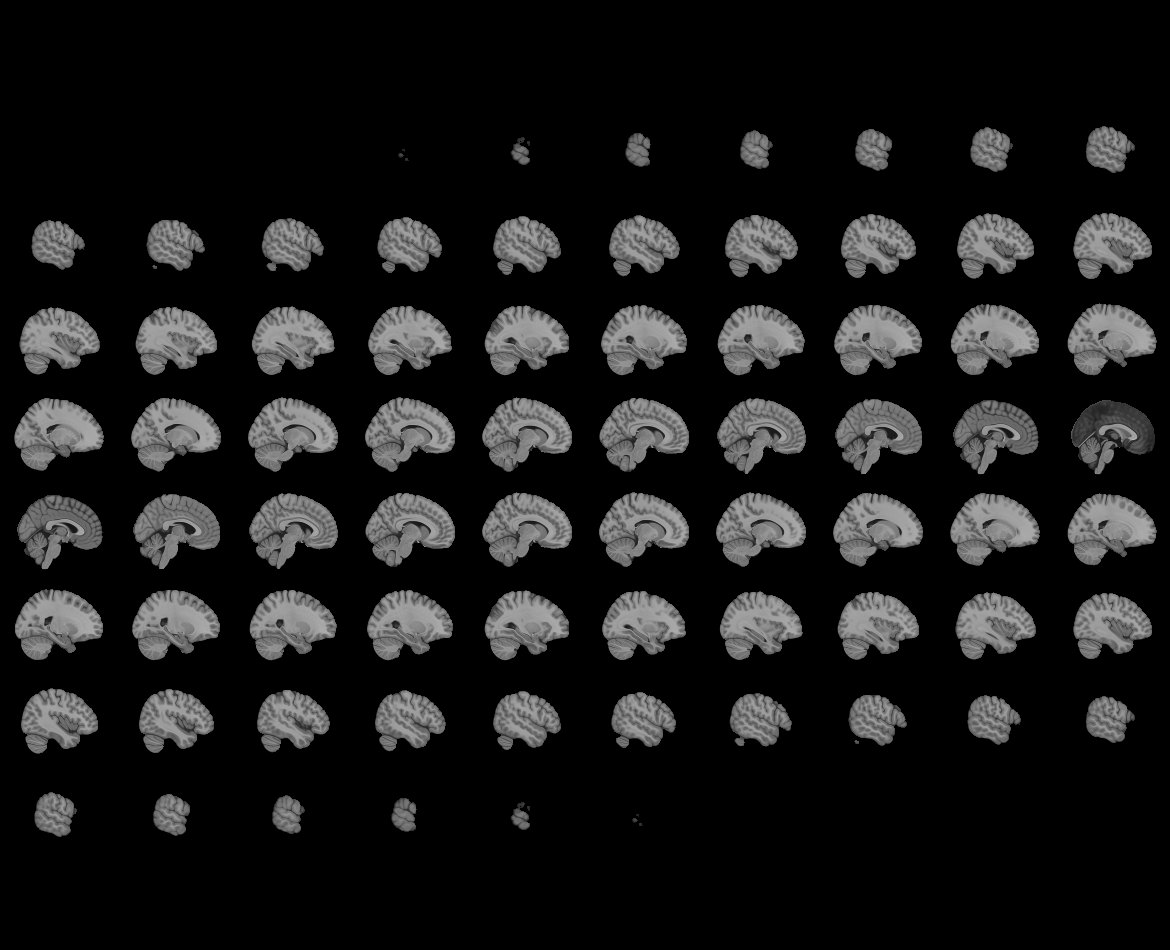

In [15]:
plotting.view_img(stat_map_img=image.index_img(y_raw, index=10))

In [16]:
mask = simage.load_mask(subj=subj)
mask.shape

(116, 116, 57)

In [17]:
y_raw = simage.masking_data(data=y_raw, mask=mask)
y_raw.shape

(116, 116, 57, 407)

/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



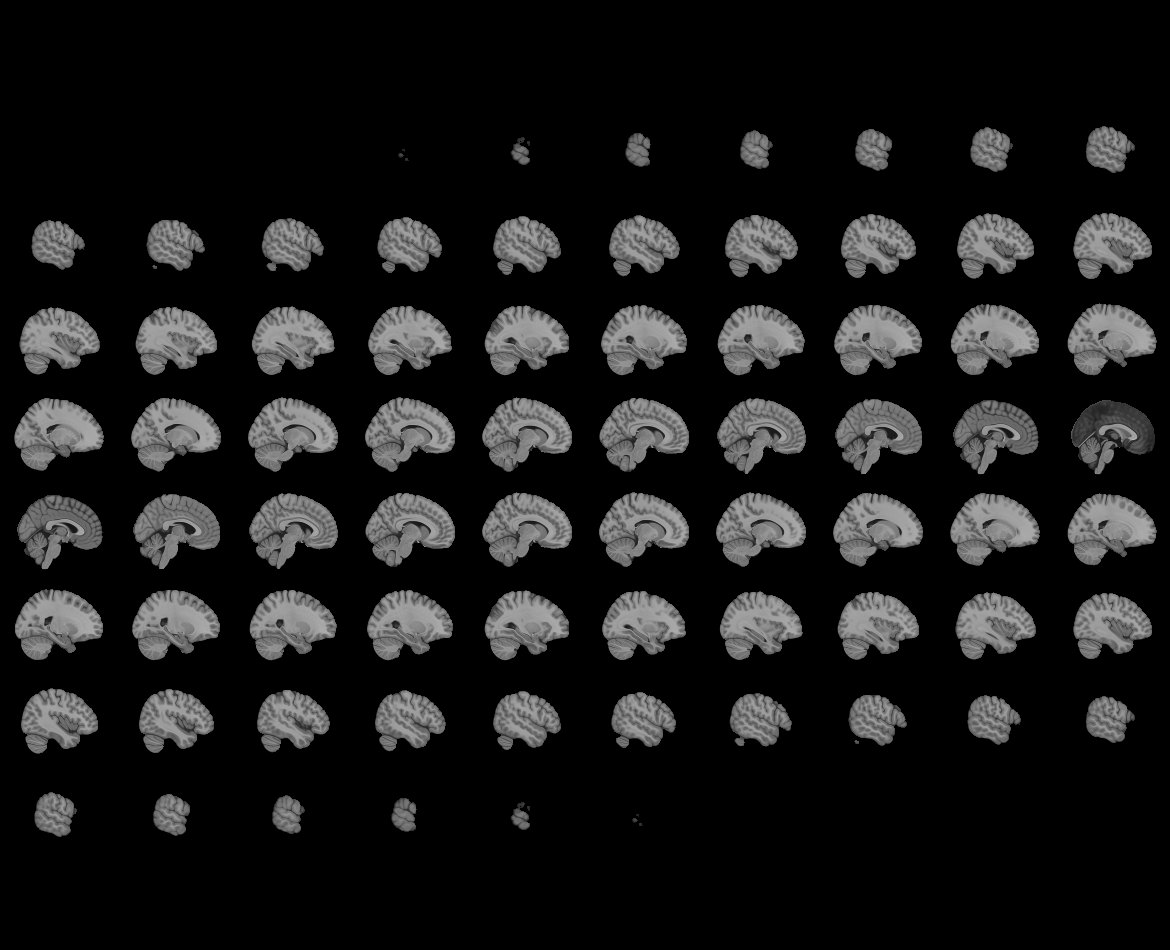

In [18]:
plotting.view_img(stat_map_img=image.index_img(y_raw, index=10))

In [19]:
tmp = mask.get_fdata()
V = tmp > 0
V.shape

(116, 116, 57)

In [20]:
tmp = y_raw.get_fdata()[V,:]
tmp.shape

(214338, 407)

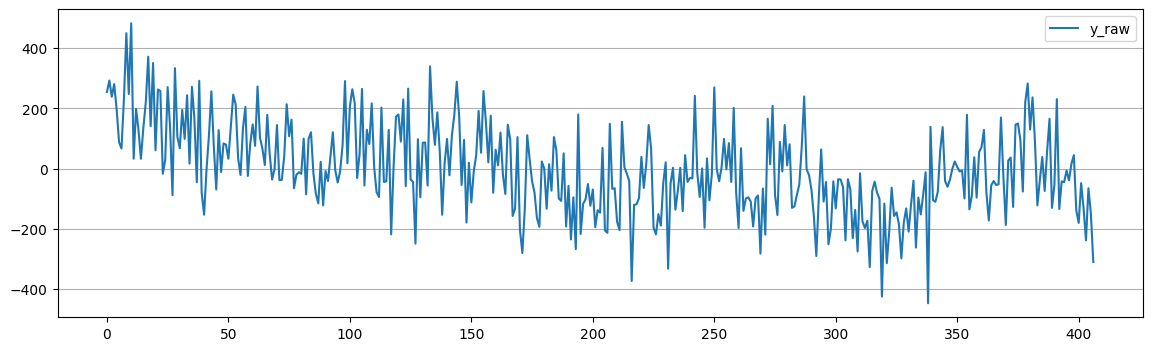

In [21]:
x = np.arange(tmp.shape[-1])
idx = 10
# idx = np.unravel_index(np.nanargmax(R2[:].flatten()),np.shape(R2))
y = tmp[idx,:]

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(x,y-y.mean(), label='y_raw')
ax.grid(axis='y')
ax.legend()

---

In [22]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

---

In [23]:
fname = join(dir_glm, subj,'DESIGNINFO.mat')
DESIGNINFO = h5py.File(fname)
DESIGNINFO.keys()

<KeysViewHDF5 ['#refs#', 'condcounts', 'condinruns', 'design', 'designSINGLE', 'endbuffers', 'numtrialrun', 'opt', 'stimdur', 'stimorder', 'tr']>

In [24]:
designSINGLE = DESIGNINFO['designSINGLE']
designSINGLE.shape

(8, 1)

In [25]:
stimdur = DESIGNINFO['stimdur'][:].flatten()[0]
tr = DESIGNINFO['tr'][:].flatten()[0]
print(stimdur, tr)

2.0 1.0


---

In [26]:
fname = join(dir_glm, subj, 'TYPED_FITHRF_GLMDENOISE_RR.mat')
GLMsingle = h5py.File(fname)
GLMsingle.keys()

<KeysViewHDF5 ['#refs#', 'FRACvalue', 'HRFindex', 'HRFindexrun', 'R2', 'R2run', 'glmbadness', 'meanvol', 'modelmd', 'noisepool', 'pcnum', 'pcregressors', 'pcvoxels', 'rrbadness', 'scaleoffset', 'xvaltrend']>

(57, 116, 116)
(116, 116, 57)


/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:205: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



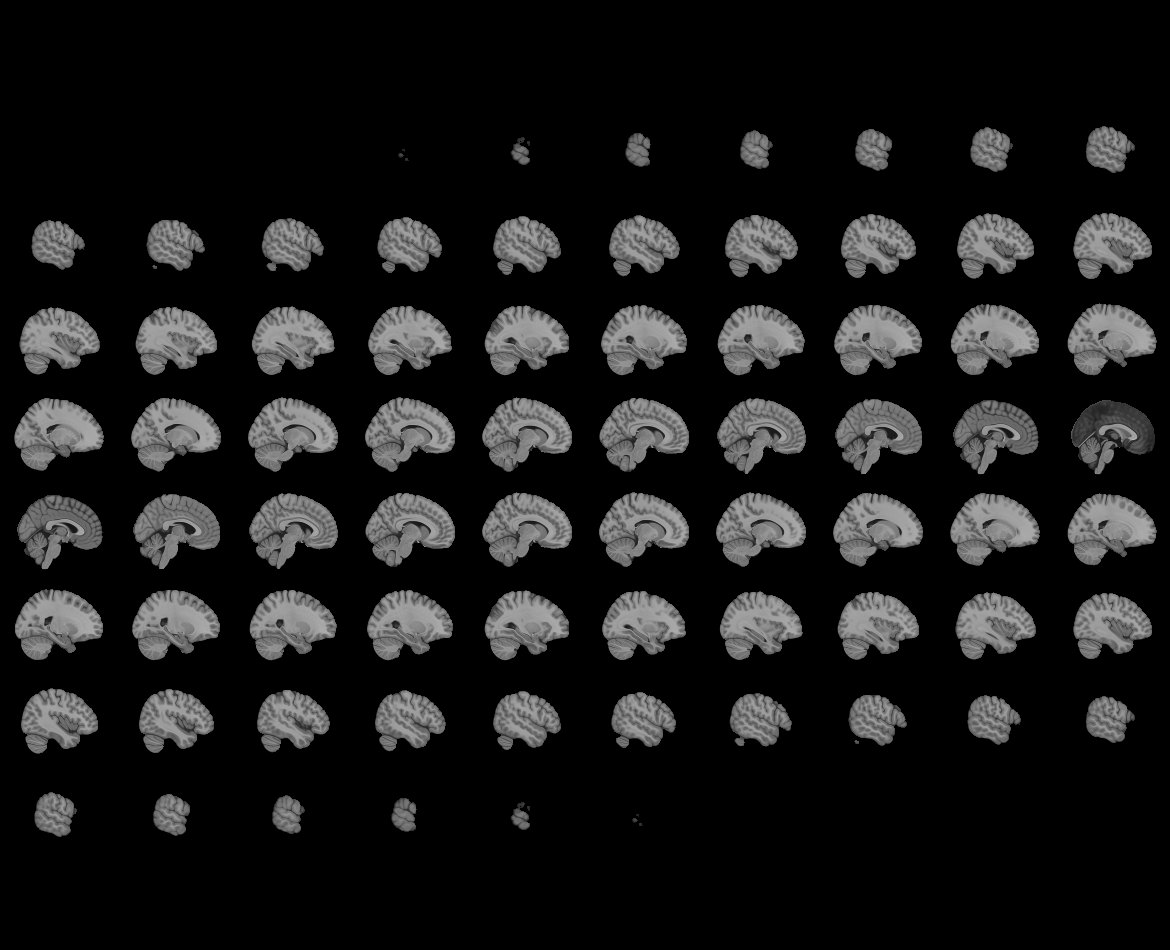

In [71]:
#Find a voxel with highest variance explained of the ON-OFF model
R2 = GLMsingle['R2'][:]
print(R2.shape)
R2 = R2.transpose(2,1,0)
print(R2.shape)
plotting.view_img(nb.Nifti1Image(R2, affine=mask.affine, header=mask.header), symmetric_cmap=False, cmap=cm.Reds)

In [51]:
# Find voxel's betas
betas = GLMsingle['modelmd'][:]
betas.shape

(544, 57, 116, 116)

In [ ]:
betas = betas.transpose(3,2,1,0)
betas.shape

In [56]:
#find hrf estimated by GLMsingle
hrflib = getcanonicalhrflibrary(stimdur,tr).T
print(hrflib.shape)
sns.lineplot(hrflib)

(52, 20)


<Axes: >

(57, 116, 116)
(116, 116, 57)


/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:109: UserWarning: Threshold given was 1e-06, but the data has no values below 1.0. 
  warnings.warn(
/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



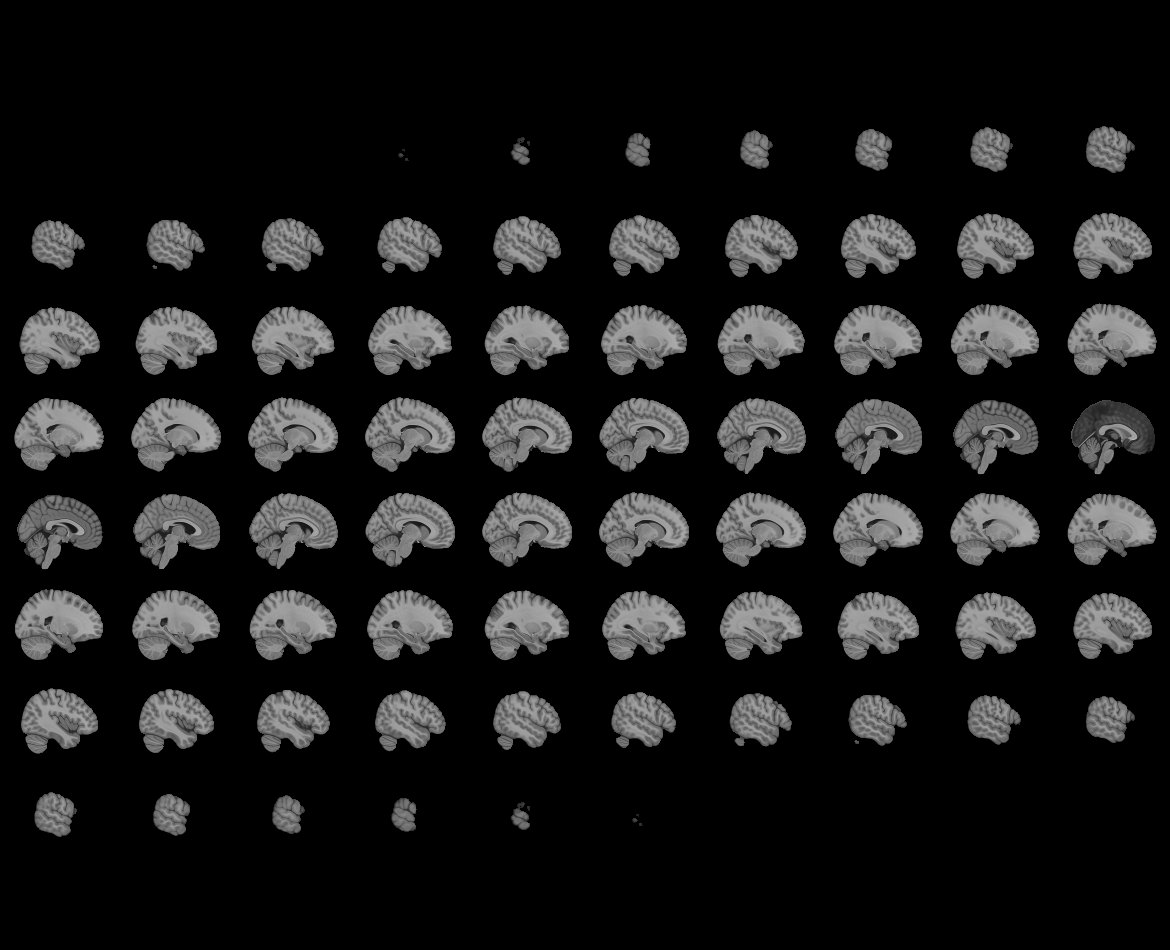

In [70]:
hrfii = GLMsingle['HRFindex'][:]
print(hrfii.shape)
hrfii = hrfii.transpose(2,1,0)
print(hrfii.shape)
plotting.view_img(nb.Nifti1Image(hrfii, affine=mask.affine, header=mask.header), vmin=0, vmax=20, symmetric_cmap=False, cmap=cm.Reds)

In [101]:
# hrfii = squish(GLMsingle['HRFindex'],3)[np.nanargmax(R2.flatten())].astype(int) - 1
# print(hrfii)
meansignal = squish(GLMsingle['meanvol'],3)[np.nanargmax(R2.flatten())]
print(meansignal)

(52, 20)
19
5688.0537


---

In [102]:
ref = designSINGLE[run-1,0]
ref

<HDF5 object reference>

<Axes: >

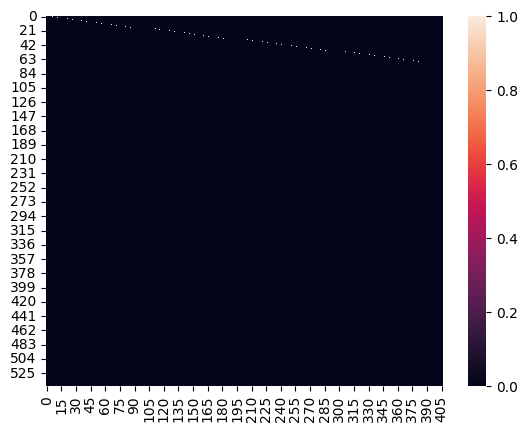

In [103]:
Xs = DESIGNINFO[ref][:]
sns.heatmap(Xs)

---

In [104]:
# convert each run design matrix from sparse array to full numpy array, append
mydesign = Xs.T
mydata = y_raw.get_fdata()
myhrf = hrflib[:,hrfii]
myhrf = myhrf.reshape(1,len(myhrf))

In [106]:
# convolve HRF into design matrix
design0 = scipy.signal.convolve2d(mydesign,myhrf).transpose()
design0 = design0[0:np.shape(mydesign)[1],:]
betatemp = betas*0.01 * meansignal
predicted = design0.T @ betatemp

#zeromean predicted tcs
predicted = predicted - np.mean(predicted)

In [111]:
ax.plot(x, predicted, label='predicted')
ax.legend()

---

In [ ]:
list_sn = su.get_list_sn()

In [ ]:
glm = 1
for nn in tqdm(list_sn):
    subj = 'S'+nn
    ssingle.calc_y_hat(subj=subj, glm=glm)

---

In [ ]:
list_run = su.get_list_run()

---

In [ ]:
Xs = ssingle.get_designSINGLE(subj,glm,run=1)
Xs.shape

In [ ]:
subj = 'S01'
run = 'r01'

dir_work = join(dir_glm, subj)
fname = join(dir_work,'%s.Yhat.%s.nii'%(subj,run))
fname = join(dir_work,'tmap_(1,S).nii')
img = nb.load(fname)

In [ ]:
plotting.view_img(
    # stat_map_img=image.index_img(img, index=10)
    stat_map_img=img
)

---

In [ ]:
run = 1

In [ ]:
y_raw, affine, header = ssingle.get_y_raw(subj=subj, glm=glm, run=run)

## check the validation
assert y_raw.shape[-1] == T, f'T mismatch: X has {T} rows, y has {y_raw.shape[-1]} timepoints'

## Flattened in 2D for vectorized operations
Y_2d = y_raw.reshape(*spatial_shape, T).reshape(V, T).T  # (T, V)
del y_raw

In [ ]:
## get y_res
R = Y_2d - Y_hat  # (T, V)

In [ ]:
voxel = 400000
plt.plot(np.arange(T),Y_2d[:,voxel])
plt.plot(np.arange(T),Y_hat[:,voxel])
# plt.plot(np.arange(T),R[:,voxel])